In [1]:
import math
import pandas as pd
import numpy as np
from enum import Enum
from numpy.random.mtrand import randint
from matplotlib import pyplot

In [2]:
class DistFunc(Enum):
    manhattan = "manhattan"
    euclidean = "euclidean"
    chebyshev = "chebyshev"


class KernelType(Enum):
    uniform = "uniform"
    triangular = "triangular"
    epanechnikov = "epanechnikov"
    quartic = "quartic"
    triweight = "triweight"
    tricube = "tricube"
    gaussian = "gaussian"
    cosine = "cosine"
    logistic = "logistic"
    sigmoid = "sigmoid"


class WidthType(Enum):
    fixed = "fixed"
    variable = "variable"

In [3]:
def distance(dist, a, b):
    res = 0.0
    temp = min(len(a), len(b))
    if dist == DistFunc.manhattan:
        for i in range(temp):
            res += abs(a[i] - b[i])
    elif dist == DistFunc.euclidean:
        for i in range(temp):
            res += pow((a[i] - b[i]), 2)
        res = math.sqrt(res)
    elif dist == DistFunc.chebyshev:
        for i in range(temp):
            res = max(res, abs(a[i] - b[i]))
    return res

In [4]:
def knn(kernel, dist, h):
    u = dist / h
    if kernel == KernelType.uniform:
        if u < 1:
            return 0.5
        else:
            return 0.0
    elif kernel == KernelType.triangular:
        if u < 1:
            return 1 - u
        else:
            return 0.0
    elif kernel == KernelType.epanechnikov:
        if u < 1:
            return 0.75 * (1 - (u * u))
        else:
            return 0.0
    elif kernel == KernelType.quartic:
        if u < 1:
            return (15.0 / 16.0) * pow(1 - pow(u, 2), 2)
        else:
            return 0.0
    elif kernel == KernelType.triweight:
        if u < 1:
            return (35.0 / 32.0) * pow(1 - pow(u, 2), 3)
        else:
            return 0.0
    elif kernel == KernelType.tricube:
        if u < 1:
            return (70.0 / 81.0) * pow(1 - pow(u, 3), 3)
        else:
            return 0.0
    elif kernel == KernelType.gaussian:
        return 1 / math.sqrt(2 * math.pi) * (math.exp(-0.5 * pow(u, 2)))
    elif kernel == KernelType.cosine:
        if u < 1:
            return (math.pi / 4) * math.cos((math.pi / 2) * u)
        else:
            return 0.0
    elif kernel == KernelType.logistic:
        return 1 / (math.exp(u) + 2 + math.exp(-u))
    elif kernel == KernelType.sigmoid:
        return 2 / (math.pi * (math.exp(u) + math.exp(-u)))

In [5]:
def minmax(dataset):
    minmax = list()
    for i in range(len(dataset[0])):
        if i == len(dataset[0]) - 1:
            continue
        value_min = dataset[:, i].min()
        value_max = dataset[:, i].max()
        minmax.append([value_min, value_max])
    return minmax

In [6]:
def normalize(dataset, minmax):
    for row in dataset:
        for i in range(len(row)):
            if i == len(row) - 1:
                continue
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

    return dataset

In [7]:
def cross_v(c, m):
    c.sort()
    res = [[] for i in range(m)]
    for i in range(len(c)):
        res[i % m].append(c[i])
    return res

In [8]:
def f_score(conf, k=3):
    f_score = [0] * k
    precision = [0] * k
    recall = [0] * k
    sum_i = [0] * k
    sum_j = [0] * k

    for i in range(k):
        for j in range(k):
            sum_i[i] += conf[i][j]
            sum_j[i] += conf[j][i]

    accuracy = 0
    a = sum(sum_i)

    for i in range(k):
        accuracy += conf[i][i]

    accuracy /= a

    for c in range(k):
        precision[c] = 0 if sum_i[c] == 0 else (conf[c][c]) / (sum_i[c])
        recall[c] = 0 if sum_j[c] == 0 else (conf[c][c]) / (sum_j[c])
        if (precision[c] + recall[c] == 0):
            f_score[c] += 0.0
        else:
            f_score[c] += 2 * (precision[c] * recall[c]) / (precision[c] + recall[c])

    micro = sum([f_score[i] * sum_i[i] for i in range(k)]) / a
    macro_prec = sum([precision[i] * sum_i[i] for i in range(k)]) / a
    macro_rec = sum([recall[i] * sum_i[i] for i in range(k)]) / a

    if (macro_prec + macro_rec == 0):
        macro = 0.0
    else:
        macro = 2 * macro_prec * macro_rec / (macro_prec + macro_rec)

    return macro

In [9]:
def params_generate():
    result = []
    for kernel in KernelType:
        for func in DistFunc:
            for width in WidthType:
                matrix = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
                m = randint(1, len(data_n))
                if width == WidthType.variable:
                    h = randint(0, len(dataset.values))
                else:
                    h = randint(0, 5)
                temp = cross_v(data_n, m)
                for i in range(m):
                    for j in range(len(temp[i])):
                        target = temp[i][j]
                        ans = k_func(func, kernel, width, h, target[:7])
                        if ans == target[7]:
                            k = int(target[7]) - 1
                            matrix[k][k] += 1
                        else:
                            k = int(target[7]) - 1
                            s = int(ans) - 1
                            matrix[k][s] += 1

                result.append([f_score(matrix), kernel, func, width, h])
    result.sort(key=lambda x: x[0], reverse=True)
    for i in range(len(result)):
        if result[i][3] == WidthType.variable:
            f_variable.append([result[i][4], result[i][0]])
        else:
            f_fixed.append([result[i][4], result[i][0]])
    return result[0]

In [10]:
def k_func(disFunc, kernelT, wType, h, target):
    dis_es = []
    for i in range(len(data_n)):
        dis_es.append([distance(disFunc, data_n[i], target), i, data_n[i][7]])
    sorted(dis_es, key=lambda x: x[0])
    res = 0
    a = 0
    b = 0
    if wType == WidthType.variable:
        h = dis_es[h][0]
    if h == 0:
        if data_n[dis_es[0][1]][:7] in target:
            idx = 0
            for i in range(len(dis_es)):
                if data_n[dis_es[i][1]][:7] in target:
                    res += dis_es[i][2]
                    idx += 1
            res /= idx
            return res
        else:
            for i in range(len(dis_es)):
                res += dis_es[i][2]
            res /= 210
            return res
    else:
        for i in range(len(dis_es)):
            a += 7 * (dis_es[i][2] * knn(kernelT, dis_es[i][0], h))
            b += 7 * knn(kernelT, dis_es[i][0], h)
        if b == 0:
            for i in range(len(dis_es)):
                res += dis_es[i][2]
            res /= 210
        else:
            res = a / b
    return res

In [11]:
dataset = pd.read_csv('seismic-bumps.csv', sep=',')
min_max = minmax(dataset.values)

data_n = normalize(dataset.values, min_max)

f_variable = []
fs_v = []
f_fixed = []
fs_f = []
h_variable = []
k_fixed = []

target = np.array([12.3, 13.34, 0.8684, 5.243, 2.974, 5.637, 5.063])
for i in range(target.size):
    target[i] = (target[i] - min_max[i][0]) / (min_max[i][1] - min_max[i][0])

best = params_generate()
f_variable.sort(key=lambda x: x[0])
f_fixed.sort(key=lambda x: x[0])
for i in range(len(f_variable)):
    h_variable.append(f_variable[i][0])
    fs_v.append(f_variable[i][1])
    
for i in range(len(f_fixed)):
    k_fixed.append(f_fixed[i][0])
    fs_f.append(f_fixed[i][1])    
print(best)
target_class = k_func(best[2], best[1], best[3], best[4], target)
if target_class <= 1.5:
    target_class = 1
elif 1.5 < target_class <= 2.5:
    target_class = 2
else:
    target_class = 3
print(target_class)

[0.4327585361538117, <KernelType.quartic: 'quartic'>, <DistFunc.manhattan: 'manhattan'>, <WidthType.variable: 'variable'>, 70]
2


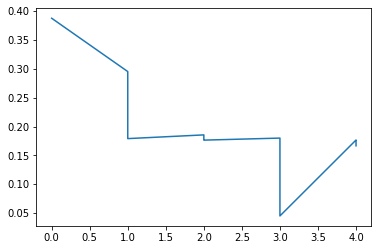

In [12]:
pyplot.plot(k_fixed, fs_f) 

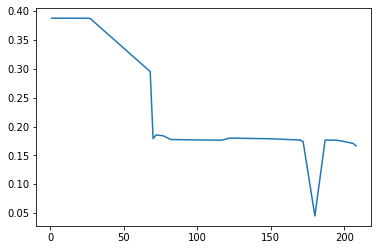

In [13]:
pyplot.plot(h_variable, fs_f) 